<a href="https://colab.research.google.com/github/angelalin01/Image-and-Document-Classification/blob/main/Image%20and%20Document%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls

drive/  sample_data/


In [ ]:
%cd drive
%ls

/content/drive
MyDrive/


In [ ]:
%cd 'My Drive/Colab Notebooks'
%ls

/content/drive/My Drive/Colab Notebooks
 cis519hw4.ipynb               'Copy of Copy of CIS419519_HW4.ipynb'
'Copy of CIS419519_HW4.ipynb'   data/


# 1 Neural Networks [40 points]

The areas where you need to make changes are marked with *TODO*


In [ ]:
# Running this cell will download the CIFAR data to the machine that the
# notebook is running on. You may need to rerun this every time you open
# the notebook
!wget https://www.seas.upenn.edu/~ddeutsch/train_images.npy
!wget https://www.seas.upenn.edu/~ddeutsch/train_labels.npy
!wget https://www.seas.upenn.edu/~ddeutsch/valid_images.npy
!wget https://www.seas.upenn.edu/~ddeutsch/valid_labels.npy
!wget https://www.seas.upenn.edu/~ddeutsch/test_images.npy
!wget https://www.seas.upenn.edu/~ddeutsch/test_labels.npy

In [ ]:
import matplotlib.pyplot as plt
import numpy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.special import softmax

In [ ]:
# This cell has the code to load the datasets. You should not need
# to edit this cell unless you want to do the extra credit. If you do
# you should only need to edit normalize_images.
class CIFARDataset(Dataset):
  def __init__(self, X, y):
    self.len = len(X)
    self.X = torch.FloatTensor(X).cuda()
    self.y = torch.LongTensor(y).cuda()
  
  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]


def normalize_images(X_train, X_valid, X_test):
  """
  Normalizes the images based on the means and standard deviations
  of the training channels. Returns the new normalized images.
  """
  std = []
  mu = []

  std = np.std(X_train[:, 0, :, :])
  mu = np.average(X_train[:, 0, :, :])
  X_train[:, 0, :, :] = (X_train[:, 0, :, :] - mu)/std
  X_valid[:, 0, :, :] = (X_valid[:, 0, :, :] - mu)/std
  X_test[:, 0, :, :] = (X_test[:, 0, :, :] - mu)/std

  std = np.std(X_train[:, 1, :, :])
  mu = np.average(X_train[:, 1, :, :])
  X_train[:, 1, :, :] = (X_train[:, 1, :, :] - mu)/std
  X_valid[:, 1, :, :] = (X_valid[:, 1, :, :] - mu)/std
  X_test[:, 1, :, :] = (X_test[:, 1, :, :] - mu)/std

  std = np.std(X_train[:, 2, :, :])
  mu = np.average(X_train[:, 2, :, :])
  X_train[:, 2, :, :] = (X_train[:, 2, :, :] - mu)/std
  X_valid[:, 2, :, :] = (X_valid[:, 2, :, :] - mu)/std
  X_test[:, 2, :, :] = (X_test[:, 2, :, :] - mu)/std

  # TODO Implement this method for the extra credit experiments
  return X_train, X_valid, X_test
    

def load_datasets(normalize=False):
  X_train = np.load('train_images.npy').astype(float)
  y_train = np.load('train_labels.npy')
  X_valid = np.load('valid_images.npy').astype(float)
  y_valid = np.load('valid_labels.npy')
  X_test = np.load('test_images.npy').astype(float)
  y_test = np.load('test_labels.npy')

  if normalize:
    X_train, X_valid, X_test = normalize_images(X_train, X_valid, X_test)
  
  train_data = CIFARDataset(X_train, y_train)
  valid_data = CIFARDataset(X_valid, y_valid)
  test_data = CIFARDataset(X_test, y_test)
  
  return train_data, valid_data, test_data

In [ ]:
# This is the implementation of the first network architecture. We have
# started it, but you need to finish it. Do not change the class name
# or the name of the data members "fc1" or "fc2"
class FeedForward(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(3072, 1000)
    # TODO
    # You need to add the second layer's parameters
        self.fc2 = torch.nn.Linear(1000, 10)
    def forward(self, X):
        batch_size = X.size(0)
    # This next line reshapes the tensor to be size (B x 3072)
    # so it can be passed through a linear layer.
        X = X.view(batch_size, -1)
    # TODO
    # You need to pass X through the two linear layers and relu
    # then return the final scores
    
        X = self.fc1(X)
        X = F.relu(X)
        X = self.fc2(X)
        return X
    

In [ ]:
# This is the implementation of the second network architecture. We have
# started it, but you need to finish it. Do not change the class name
# or the name of the data members "conv1", "pool", "conv2", "fc1", "fc2",
# or "fc3".

class Convolutional(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(in_channels=3,
                                 out_channels=7,
                                 kernel_size=3,
                                 stride=1,
                                 padding=0)
    # TODO
    # You need to add the pooling, second convolution, and
    # three linear modules here
    self.pool = torch.nn.MaxPool2d(kernel_size=2,stride=2)
    self.conv2 = torch.nn.Conv2d(in_channels=7,
                                 out_channels=16,
                                 kernel_size=3,
                                 stride=1,
                                 padding=0)
    self.fc1 = torch.nn.Linear(2704, 130)
    self.fc2 = torch.nn.Linear(130, 72)
    self.fc3 = torch.nn.Linear(72, 10)

  def forward(self, X):
    batch_size = X.size(0)
    X = self.conv1(X)
    X = self.pool(X)
    X = self.conv2(X)
    X = F.relu(X)
    X = X.view(X.size(0), -1)
    X = self.fc1(X)
    X = F.relu(X)
    X = self.fc2(X)
    X = F.relu(X)
    X = self.fc3(X)
    X = torch.sigmoid(X)

    return X


In [ ]:
# You need to finish implementing this method
def compute_loss_and_accuracy(network, data_loader):
  """
  Given a network, iterate over the dataset defined by the data_loader
  and compute the accuracy of the model and the average loss.
  """
  # This should be used to accumulate the total loss on the dataset
  total_loss = 0

  # This should count how many examples were correctly classified.
  num_correct = 0

  # This should count the number of examples in the dataset. (Be careful
  # because it should -not- be the number of batches.)
  num_instances = 0

  # The CrossEntropyLoss by default will return the average loss
  # for the batch. So, when you accumulate the total_loss, make sure
  # to multiply the loss computed by CrossEntropyLoss by the batch size
  cross_entropy_loss = torch.nn.CrossEntropyLoss()

  for X, y in data_loader:
    # TODO
    with torch.no_grad():
      output = network(X)
  
      _, output_max = torch.max(output, 1)
      num_correct = num_correct + (output_max == y).sum().item()

      loss = cross_entropy_loss(output, y)
      batch_size = X.size(0)
      total_loss = total_loss + batch_size * loss
      num_instances = num_instances + y.size(0);
  
  accuracy = num_correct / num_instances * 100
  average_loss = total_loss / num_instances
  return accuracy, average_loss

In [ ]:
# You need to finish implementing this method
def run_experiment(network, train_data_loader, valid_data_loader, optimizer):
  # This will be a list of the average training losses for each epoch
  train_losses = []
  # This will be a list of the average validation losses for each epoch
  valid_accs = []
  # This will be a list of the validation accuracies for each epoch
  valid_losses = []
  # The CrossEntropyLoss by default will return the average loss
  # for the batch. So, when you accumulate the total_loss, make sure
  # to multiply the loss computed by CrossEntropyLoss by the batch size
  cross_entropy_loss = torch.nn.CrossEntropyLoss()
  for epoch in range(200):
    # This should be used to accumulate the total loss on the training data
    total_loss = 0.0
    # This should be used to count the number of training examples. (Be careful
    # because this is not the number of batches)
    num_instances = 0
    num_correct = 0
    for X, y in train_data_loader:
      # TODO
      # You need to implement computing the loss for this batch
      # and updating the model's parameters.
      optimizer.zero_grad()
      #calculate correct examples
      output = network(X)
      
      _, output_max = torch.max(output, 1)
      num_correct = num_correct + (output_max == y).sum().item()

      #loss computation
      loss = cross_entropy_loss(output, y)
      batch_size = X.size(0)
      total_loss = total_loss + batch_size * loss
      loss.backward()
      optimizer.step()

      # total examples
      num_instances = num_instances + y.size(0);

    train_loss = total_loss / num_instances
    valid_acc, valid_loss = compute_loss_and_accuracy(network, valid_data_loader)
    train_losses.append(train_loss)
    valid_accs.append(valid_acc)
    valid_losses.append(valid_loss)
  return train_losses, valid_accs, valid_losses

In [ ]:
# Load the data and create the iterators. You should not need
# to modify this cell
train_data, valid_data, test_data = load_datasets(normalize=False)
train_data_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_data_loader = DataLoader(valid_data, batch_size=64)
test_data_loader = DataLoader(test_data, batch_size=64)

In [ ]:
# TODO
# If you want to run the extra credit experiment, repeat the above experiments
# but load the normalized data.
train_data, valid_data, test_data = load_datasets(normalize=True)
train_data_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_data_loader = DataLoader(valid_data, batch_size=64)
test_data_loader = DataLoader(test_data, batch_size=64)

LR = 0.0001, Valid Acc: 40.9
LR = 5e-05, Valid Acc: 37.2
LR = 1e-05, Valid Acc: 28.299999999999997
Test Accuracy: 40.300000000000004


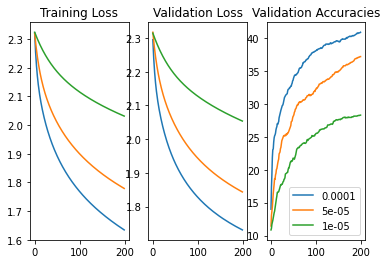

In [ ]:
# Implements the FeedForward experiment. You can base the Convolutional experiment
# on this code. You should not need to edit this cell.
best_network = None
best_acc = None

_, axs = plt.subplots(1,3)
axs[0].set_title('Training Loss')
axs[1].set_title('Validation Loss')
axs[2].set_title('Validation Accuracies')

for lr in [0.0001, 0.00005, 0.00001]:
  network = FeedForward()
  network.cuda()
  sgd = torch.optim.SGD(network.parameters(), lr=lr)

  train_losses, valid_accs, valid_losses = run_experiment(network, train_data_loader, valid_data_loader, sgd)
  valid_acc = valid_accs[-1]
  print(f'LR = {lr}, Valid Acc: {valid_acc}')
  if best_acc is None or valid_acc > best_acc:
    best_acc = valid_acc
    best_network = network

  axs[0].plot(train_losses, label=str(lr))
  axs[1].plot(valid_losses, label=str(lr))
  axs[2].plot(valid_accs, label=str(lr))

plt.legend()

test_acc, _ = compute_loss_and_accuracy(best_network, test_data_loader)
print('Test Accuracy: ' + str(test_acc))

LR = 0.01, Valid Acc: 48.6
LR = 0.001, Valid Acc: 30.3
LR = 0.0001, Valid Acc: 11.05
Test Accuracy: 49.1


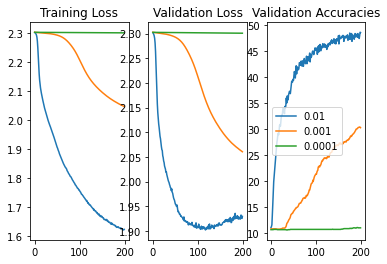

In [ ]:
# TODO
# You should implement the Convolutional experiment here. It should be
# very similar to the cell above.
best_network = None
best_acc = None

_, axs = plt.subplots(1,3)
axs[0].set_title('Training Loss')
axs[1].set_title('Validation Loss')
axs[2].set_title('Validation Accuracies')

for lr in [0.01, 0.001, 0.0001]:
  network = Convolutional()
  network.cuda()
  sgd = torch.optim.SGD(network.parameters(), lr=lr)

  train_losses, valid_accs, valid_losses = run_experiment(network, train_data_loader, valid_data_loader, sgd)
  valid_acc = valid_accs[-1]
  print(f'LR = {lr}, Valid Acc: {valid_acc}')
  if best_acc is None or valid_acc > best_acc:
    best_acc = valid_acc
    best_network = network

  axs[0].plot(train_losses, label=str(lr))
  axs[1].plot(valid_losses, label=str(lr))
  axs[2].plot(valid_accs, label=str(lr))

plt.legend()

test_acc, _ = compute_loss_and_accuracy(best_network, test_data_loader)
print('Test Accuracy: ' + str(test_acc))

## (Optional) Extra Credit

In [ ]:
# TODO
# If you want to run the extra credit experiment, repeat the above experiments
# but load the normalized data.
train_data, valid_data, test_data = load_datasets(normalize=True)
train_data_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_data_loader = DataLoader(valid_data, batch_size=64)
test_data_loader = DataLoader(test_data, batch_size=64)

# 2 Document Classification [40 Points]

##2.2 Document Representation

In [ ]:
import json

In [ ]:
from collections import defaultdict
def get_vocabulary(D):
    """
    Given a list of documents, where each document is represented as
    a list of tokens, return the resulting vocabulary. The vocabulary
    should be a set of tokens which appear more than once in the entire
    document collection plus the "<unk>" token.
    """
    vocab = set()
    vocab_freq = {}
    vocab.add("<unk>")
    # check frequencies
    for doc in D:
      for token in doc:
        if token in vocab_freq.keys():
          vocab_freq[token] += 1
        else:
          vocab_freq[token] = 1
    for token, freq in vocab_freq.items():
      if vocab_freq[token] > 1:
        vocab.add(token)
          
    return vocab

In [ ]:
class BBoWFeaturizer(object):
  def convert_document_to_feature_dictionary(self, doc, vocab):
    """
    Given a document represented as a list of tokens and the vocabulary
    as a set of tokens, compute the binary bag-of-words feature representation.
    This function should return a dictionary which maps from the name of the
    feature to the value of that feature.
    """
    feat_dict = {}
    for token in doc:
      if token in vocab:
        feat_dict[token] = 1
      else:
        feat_dict["<unk>"] = 1
    return feat_dict

In [ ]:
class CBoWFeaturizer(object):
  def convert_document_to_feature_dictionary(self, doc, vocab):
    """
    Given a document represented as a list of tokens and the vocabulary
    as a set of tokens, compute the count bag-of-words feature representation.
    This function should return a dictionary which maps from the name of the
    feature to the value of that feature.
    """
    feat_dict = {}
    for token in doc:
      if token in vocab:
        if token in feat_dict:
          feat_dict[token] += 1
        else:
          feat_dict[token] = 1
      else:
        if "<unk>" in feat_dict:
          feat_dict["<unk>"] += 1
        else:
          feat_dict["<unk>"] = 1
    return feat_dict


In [ ]:
def compute_idf(D, vocab):
    """
    Given a list of documents D and the vocabulary as a set of tokens,
    where each document is represented as a list of tokens, return the IDF scores
    for every token in the vocab. The IDFs should be represented as a dictionary that
    maps from the token to the IDF value. If a token is not present in the
    vocab, it should be mapped to "<unk>".
    """
    list_size = len(D)
    idf_scores = {}
        
    for doc in D:
        for token in vocab:
            if token in doc:
                if token not in idf_scores:
                    idf_scores[token] = 1
                else:
                    idf_scores[token] = idf_scores[token] + 1
    
        
    # account for <unk>
    idf_scores["<unk>"] = 0
    for doc in D:
        for token in doc:
            if token not in vocab:
                idf_scores["<unk>"] = idf_scores["<unk>"] + 1
                break
                
    for token, val in idf_scores.items():
        idf_scores[token] = numpy.log((list_size/val))
        
    return idf_scores
    
class TFIDFFeaturizer(object):
    def __init__(self, idf):
        """The idf scores computed via `compute_idf`."""
        self.idf = idf
    
    def convert_document_to_feature_dictionary(self, doc, vocab):
        """
        Given a document represented as a list of tokens and
        the vocabulary as a set of tokens, compute
        the TF-IDF feature representation. This function
        should return a dictionary which maps from the name of the
        feature to the value of that feature.
        """
        # TODO
        feat_dict_tf_idf = {}
        cbow = CBoWFeaturizer()
        feat_dict_tf =cbow.convert_document_to_feature_dictionary(doc, vocab)
        for token, tf in feat_dict_tf.items():
          feat_dict_tf_idf[token] = feat_dict_tf[token] * self.idf[token]
        return feat_dict_tf_idf

In [ ]:
# You should not need to edit this cell
def load_document_dataset(file_path):
    D = []
    y = []
    with open(file_path, 'r') as f:
        for line in f:
            instance = json.loads(line)
            D.append(instance['document'])
            y.append(instance['label'])
    return D, y

def convert_to_features(D, featurizer, vocab):
    X = []
    for doc in D:
        X.append(featurizer.convert_document_to_feature_dictionary(doc, vocab))
    return X

##2.3 Naive Bayes Experiment

In [ ]:
def train_naive_bayes(X, y, k, vocab):
    """
    Computes the statistics for the Naive Bayes classifier.
    X is a list of feature representations, where each representation
    is a dictionary that maps from the feature name to the value.
    y is a list of integers that represent the labels.
    k is a float which is the smoothing parameters.
    vocab is the set of vocabulary tokens.
    
    Returns two values:
        p_y: A dictionary from the label to the corresponding p(y) score
        p_v_y: A nested dictionary where the outer dictionary's key is
            the label and the innner dictionary maps from a feature
            to the probability p(v|y). For example, `p_v_y[1]["hello"]`
            should be p(v="hello"|y=1).
    """
    y_freq = {}
    p_y = {}
    p_v_y = {}
    total_labels = len(y)
    vocab_size = len(vocab)
    for label in y:
      p_v_y[label] = {}
      if label not in y_freq.keys():
        y_freq[label] = 1
      else:
        y_freq[label] = y_freq[label] + 1
    for label, freq in y_freq.items():
      p_y[label] = y_freq[label] / total_labels
    
    #calculate the denominator
    f_d_w = {}
    for label in y:
        f_d_w[label] = k * vocab_size
        for v in vocab:
            for i in range(len(X)):
                if y[i] == label:
                    if v in X[i].keys(): # check if current word in vocab is in current doc
                        f_d_w[label] = f_d_w[label] + X[i][v]

    #calculate the numerator
    for label in y: #all y we consider for the P(v|y)'s
        #f_d_v = {}
        #f_d_v[label] = {} # numerator, dictionary for all tokens in the feature space
      # f_d_w = 0 # denominator
        for v in vocab:
            p_v_y[label][v] = k
            for i in range(len(X)):
                if y[i] == label: # consider only all documents with current label of interest
                #for token, val in X[i].items(): #X[i] represents a document
                    if v in X[i].keys(): # for a given token of interrest
                        p_v_y[label][v] = p_v_y[label][v] + X[i][v]
                        
      # p_v_y_inner = {}
      #find the P(v|y)'s plus Laplace smoothing
    for label, val in p_v_y.items():
        for token, y in val.items():
            p_v_y[label][token] = y / (f_d_w[label])
      # p_v_y[label] = p_v_y_inner

    return p_y, p_v_y

In [ ]:
def predict_naive_bayes(D, p_y, p_v_y):
    """
    Runs the prediction rule for Naive Bayes. D is a list of documents,
    where each document is a list of tokens.
    p_y and p_v_y are output from `train_naive_bayes`.
    
    Note that any token which is not in p_v_y should be mapped to
    "<unk>". Further, the input dictionaries are probabilities. You
    should convert them to log-probabilities while you compute
    the Naive Bayes prediction rule to prevent underflow errors.
    
    Returns two values:
        predictions: A list of integer labels, one for each document,
            that is the predicted label for each instance.
        confidences: A list of floats, one for each document, that is
            p(y|d) for the corresponding label that is returned.
    """
    # TODO
    predictions = []
    confidences = []
    
    for doc in D:
      argmax_pyd = 0
      prediction = 0
      map = {}
      arr = []
      labels = []
      for label, val in p_y.items():
        prob_y = numpy.log(val)
        p_y_d = prob_y
        pyd_normal = val
        for token in doc:
        # check for "<unk>"
          if label in p_v_y:
            if token not in p_v_y[label]:
                token = "<unk>"
            p_y_d = p_y_d + numpy.log(p_v_y[label][token])
          # pyd_normal = pyd_normal * p_v_y[label][token]
        labels.append(p_y_d)
        map[label] = p_y_d
        arr.append(float(p_y_d))
      
        #if pyd_normal > argmax_pyd: #prediction is the label corresponding to max prob
          #argmax_pyd = p_y_d
          #prediction = label
      
      predictions.append(np.argmax(labels))
      
      confidences.append(max(softmax(arr)))
      
    
    return predictions, confidences
    

## Running experiments for document classification

In [ ]:
# Variables that are named D_* are lists of documents where each
# document is a list of tokens. y_* is a list of integer class labels.
# X_* is a list of the feature dictionaries for each document.
# TODO you likely need to update these paths for your drive setup.
%ls '/content/drive/MyDrive/Colab Notebooks/data'
D_train, y_train = load_document_dataset('/content/drive/My Drive/Colab Notebooks/data/train.jsonl')
D_valid, y_valid = load_document_dataset('/content/drive/My Drive/Colab Notebooks/data/valid.jsonl')
D_test, y_test = load_document_dataset('/content/drive/My Drive/Colab Notebooks/data/test.jsonl')

vocab = get_vocabulary(D_train)

test.jsonl  train.jsonl  valid.jsonl


In [ ]:
# Compute the features, for example, using the BBowFeaturizer.
# You actually only need to conver the training instances to their
# feature-based representations.
# 
# This is just starter code for the experiment. You need to fill in
# the rest.

from sklearn.metrics import accuracy_score

highest_accuracy_bbow = 0
highest_k_bbow = 0
highest_accuracy_cbow = 0
highest_k_cbow = 0
highest_accuracy_tfidf = 0
highest_k_tfidf = 0

for k in [0.001, 0.01, 0.1, 1.0, 10.0]:
  featurizer1 = BBoWFeaturizer()
  X_train = convert_to_features(D_train, featurizer1, vocab)
  p_y, p_v_y = train_naive_bayes_2(X_train, y_train, k, vocab)
  predictions, confidences = predict_naive_bayes(D_valid, p_y, p_v_y)
  bbow_acc = accuracy_score(predictions, y_valid)
  if bbow_acc > highest_accuracy_bbow:
    highest_accuracy_bbow = bbow_acc
    highest_k_bbow = k

print("highest k bbow: ")
print(highest_k_bbow)

# predict on test dataset
featurizer1 = BBoWFeaturizer()
X_train = convert_to_features(D_train, featurizer1, vocab)
p_y, p_v_y = train_naive_bayes_2(X_train, y_train, highest_k_bbow, vocab)
predictions, confidences = predict_naive_bayes(D_test, p_y, p_v_y)
bbow_acc = accuracy_score(predictions, y_test)
print("highest bbow acc test: ")
print(bbow_acc)


for k in [0.001, 0.01, 0.1, 1.0, 10.0]:
  featurizer2 = CBoWFeaturizer()
  X_train = convert_to_features(D_train, featurizer2, vocab)
  p_y, p_v_y = train_naive_bayes_2(X_train, y_train, k, vocab)
  predictions, confidences = predict_naive_bayes(D_valid, p_y, p_v_y)
  cbow_acc = accuracy_score(predictions, y_valid)
  if cbow_acc > highest_accuracy_cbow:
    highest_accuracy_cbow = cbow_acc
    highest_k_cbow = k

print("highest k cbow: ")
print(highest_k_cbow)

featurizer2 = CBoWFeaturizer()
X_train = convert_to_features(D_train, featurizer2, vocab)
p_y, p_v_y = train_naive_bayes_2(X_train, y_train, highest_k_cbow, vocab)
predictions, confidences = predict_naive_bayes(D_test, p_y, p_v_y)
cbow_acc = accuracy_score(predictions, y_test)
print("highest cbow acc test: ")
print(cbow_acc)


for k in [0.001, 0.01, 0.1, 1.0, 10.0]:
  featurizer3 = TFIDFFeaturizer(compute_idf(D_train, vocab))
  X_train = convert_to_features(D_train, featurizer3, vocab)
  p_y, p_v_y = train_naive_bayes_2(X_train, y_train, k, vocab)
  predictions, confidences = predict_naive_bayes(D_valid, p_y, p_v_y)
  tfidf_acc = accuracy_score(predictions, y_valid)
  if tfidf_acc > highest_accuracy_tfidf:
    highest_accuracy_tfidf = tfidf_acc
    highest_k_tfidf = k

print("highest k tfidf: ")
print(highest_k_tfidf)

featurizer3 = TFIDFFeaturizer(compute_idf(D_train, vocab))
X_train = convert_to_features(D_train, featurizer3, vocab)
p_y, p_v_y = train_naive_bayes_2(X_train, y_train, highest_k_tfidf, vocab)
predictions, confidences = predict_naive_bayes(D_test, p_y, p_v_y)
tfidf_acc = accuracy_score(predictions, y_test)
print("highest tfidf acc test: ")
print(tfidf_acc)


highest k bbow: 
0.001
highest bbow acc test: 
0.5004
highest k cbow: 
0.001
highest cbow acc test: 
0.5004


In [ ]:
def train_naive_bayes_2(X, y, k, vocab):
  p_y = {}
  p_v_y = {}
  pvy_denom = {}
  y_set = set(y)

  for val in y:
      p_y[val] = p_y[val] + (1/len(y)) if val in p_y else (1/len(y))
  
  for val in y_set:
    p_v_y[val] = {}
    denom = k* len(vocab)
    for doc_index in range(len(X)):
      if y[doc_index] == val:
        for token in X[doc_index]:
          p_v_y[val][token] = p_v_y[val][token] + X[doc_index][token] if token in p_v_y[val] else X[doc_index][token]
          denom = denom + X[doc_index][token]
    pvy_denom[val] = denom


    for v, mapping in p_v_y.items():
      for feature in vocab:
        p_v_y[v][feature] = (p_v_y[v][feature] + k) / pvy_denom[v] if feature in p_v_y[v] else k/pvy_denom[v]
    
    return p_y, p_v_y